In [ ]:
# pip install wfdb

In [2]:
import os
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

C:\Users\kaviy\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
# === 1. Load Metadata and SCP Statements ===
base_path = "C:/Users/kaviy/Downloads/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/ptb-xl-electrocardiography-dataset"
metadata_path = os.path.join(base_path, "ptbxl_database.csv")
scp_path = os.path.join(base_path, "scp_statements.csv")

df = pd.read_csv(metadata_path)
df = df[df['filename_lr'].notnull()]
scp = pd.read_csv(scp_path, index_col=0)

In [4]:
# === 2. Extract Diagnostic Class ===
df['scp_codes'] = df['scp_codes'].apply(lambda x: eval(x) if isinstance(x, str) else {})
df['first_class'] = df['scp_codes'].apply(lambda x: list(x.keys())[0] if x else 'NORM')
label_encoder = LabelEncoder()
df['class_encoded'] = label_encoder.fit_transform(df['first_class'])

In [5]:
# Calculate the counts of each class in the 'first_class' column
class_counts = df['first_class'].value_counts()

# Get the names of the top 5 classes
top_5_classes = class_counts.head(5).index.tolist()

# Filter the DataFrame to keep only the rows corresponding to the top 5 classes
df_top_5 = df[df['first_class'].isin(top_5_classes)].copy()

print(f"Original DataFrame shape: {df.shape}")
print(f"DataFrame shape after keeping top 5 classes: {df_top_5.shape}")
print("Top 5 classes:", top_5_classes)
display(df_top_5.head())

Original DataFrame shape: (21799, 30)
DataFrame shape after keeping top 5 classes: (16397, 30)
Top 5 classes: ['NORM', 'IMI', 'ASMI', 'NDT', 'LVH']


,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,first_class,class_encoded
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,NORM,38
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,NORM,38
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,NORM,38
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,NORM,38
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,NORM,38


In [6]:
df=df_top_5

In [7]:
# === 3. Read ECG Signal ===
def read_ecg(rel_path, base_dir):
    full_path = os.path.join(base_dir, rel_path)
    record = wfdb.rdrecord(full_path)
    return record.p_signal


In [8]:
# === 4. Build Dataset ===
def build_dataset(df, base_dir, max_len=1000, use_lead=0):
    X, y, lengths = [], [], []
    for _, row in df.iterrows():
        try:
            signal = read_ecg(row['filename_lr'], base_dir)
            signal = signal[:, use_lead]
            lengths.append(len(signal))  
            if len(signal) > max_len:
                signal = signal[:max_len]
            else:
                signal = np.pad(signal, (0, max_len - len(signal)), 'constant')
            X.append(signal)
            y.append(row['class_encoded'])
        except Exception as e:
            print(f"Error reading {row['filename_lr']}: {e}")
    df['length'] = lengths
    return np.array(X), np.array(y), df

In [9]:
# === 5. Load ECG Data ===
X, y, df = build_dataset(df, base_path, max_len=1000, use_lead=0)

In [10]:
df.head()

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,first_class,class_encoded,length
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,NORM,38,1000
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,NORM,38,1000
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,NORM,38,1000
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,NORM,38,1000
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,NORM,38,1000


In [11]:
df = df.dropna(axis=1, how='all')

In [12]:
# === 6. Preprocessing ===
X = X[..., np.newaxis]
y_cat = to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)
y_train_flat = np.argmax(y_train, axis=1)
y_test_flat = np.argmax(y_test, axis=1)

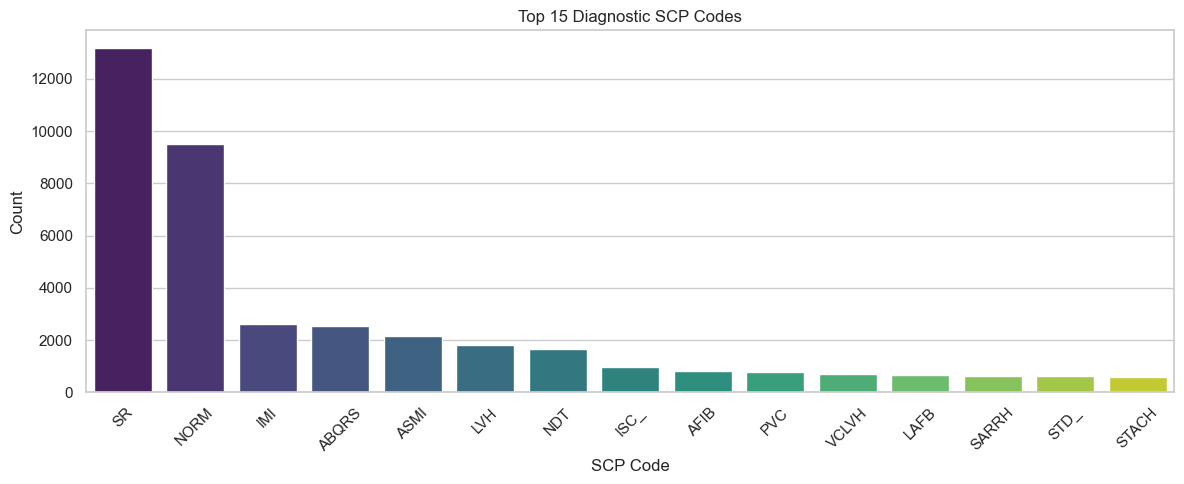

In [13]:
# === EDA ===
sns.set(style="whitegrid")

# Top 15 SCP Diagnostic Codes
df['all_classes'] = df['scp_codes'].apply(lambda x: list(x.keys()))
all_codes_flat = pd.Series([code for sublist in df['all_classes'] for code in sublist])
top_classes = all_codes_flat.value_counts().head(15).reset_index()
top_classes.columns = ['scp_code', 'count']
top_classes = top_classes.merge(scp[['description']], left_on='scp_code', right_index=True, how='left')

plt.figure(figsize=(12, 5))
sns.barplot(x='scp_code', y='count', data=top_classes, palette='viridis')
plt.title("Top 15 Diagnostic SCP Codes")
plt.xlabel("SCP Code")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
print(df.columns)

Index(['ecg_id', 'patient_id', 'age', 'sex', 'height', 'weight', 'nurse',
       'site', 'device', 'recording_date', 'report', 'scp_codes', 'heart_axis',
       'infarction_stadium1', 'infarction_stadium2', 'validated_by',
       'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
       'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr',
       'first_class', 'class_encoded', 'length', 'all_classes'],
      dtype='object')


C:\Users\kaviy\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


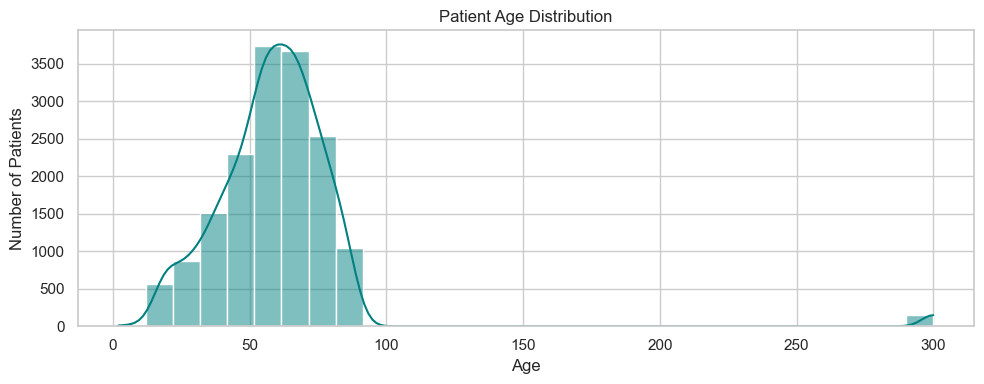

In [15]:
# Age Distribution
plt.figure(figsize=(10, 4))
sns.histplot(df['age'], bins=30, kde=True, color="teal")
plt.title("Patient Age Distribution")
plt.xlabel("Age")
plt.ylabel("Number of Patients")
plt.tight_layout()
plt.show()

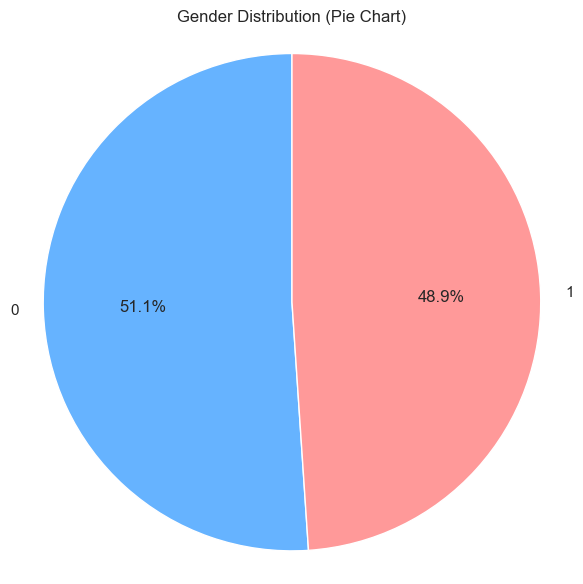

In [16]:
# Gender Distribution

gender_counts = df['sex'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'])
plt.title("Gender Distribution (Pie Chart)")
plt.axis('equal')
plt.tight_layout()
plt.show()


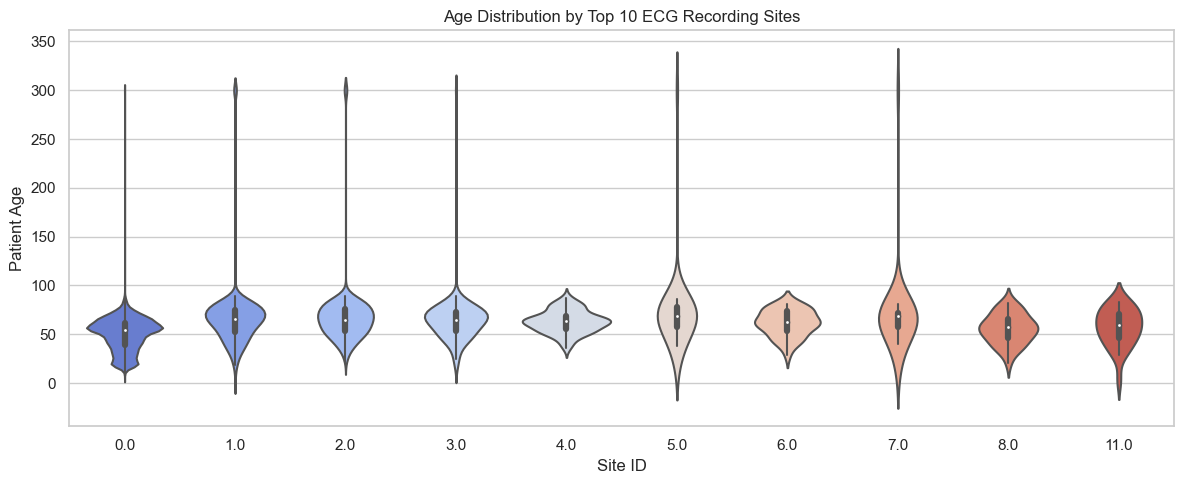

In [17]:
# Filter top 10 ECG sites
top_sites = df['site'].value_counts().head(10).index
df_top_sites = df[df['site'].isin(top_sites)].copy()

plt.figure(figsize=(12, 5))
sns.violinplot(x='site', y='age', data=df_top_sites, palette='coolwarm')
plt.title("Age Distribution by Top 10 ECG Recording Sites")
plt.xlabel("Site ID")
plt.ylabel("Patient Age")
plt.tight_layout()
plt.show()

In [18]:
# ===  CNN Model ===
model = Sequential([
    Conv1D(32, kernel_size=5, activation='relu', input_shape=(X.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_cat.shape[1], activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
# ===  Train CNN ===
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
410/410 [==============================] - 20s 46ms/step - loss: 1.3560 - accuracy: 0.5637 - val_loss: 1.1921 - val_accuracy: 0.5902
Epoch 2/10
410/410 [==============================] - 19s 47ms/step - loss: 1.1243 - accuracy: 0.6017 - val_loss: 1.0651 - val_accuracy: 0.6113
Epoch 3/10
410/410 [==============================] - 18s 43ms/step - loss: 1.0540 - accuracy: 0.6220 - val_loss: 1.0362 - val_accuracy: 0.6216
Epoch 4/10
410/410 [==============================] - 20s 48ms/step - loss: 1.0068 - accuracy: 0.6364 - val_loss: 1.0429 - val_accuracy: 0.6165
Epoch 5/10
410/410 [==============================] - 18s 43ms/step - loss: 0.9512 - accuracy: 0.6573 - val_loss: 1.0307 - val_accuracy: 0.6162
Epoch 6/10
410/410 [==============================] - 18s 44ms/step - loss: 0.9137 - accuracy: 0.6667 - val_loss: 1.0501 - val_accuracy: 0.6293
Epoch 7/10
410/410 [==============================] - 18s 43ms/step - loss: 0.8505 - accuracy: 0.6892 - val_loss: 1.0746 - val_accuracy:

In [20]:
# ===  CNN Predictions ===
y_pred_cnn = np.argmax(model.predict(X_test), axis=1)

103/103 [==============================] - 1s 9ms/step


In [21]:
# ===  SVM & Random Forest ===
X_flat = X.reshape((X.shape[0], -1))
X_train_flat, X_test_flat, y_train_svm, y_test_svm = train_test_split(X_flat, y, test_size=0.2, random_state=42)

In [22]:
svm = SVC(kernel='rbf')
svm.fit(X_train_flat, y_train_svm)
y_pred_svm = svm.predict(X_test_flat)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_flat, y_train_svm)
y_pred_rf = rf.predict(X_test_flat)


In [23]:
# ===  Evaluation ===
def get_metrics(y_true, y_pred, name):
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average='weighted', zero_division=0),
        "Recall": recall_score(y_true, y_pred, average='weighted', zero_division=0),
        "F1-Score": f1_score(y_true, y_pred, average='weighted', zero_division=0)
    }

results = [
    get_metrics(y_test_flat, y_pred_cnn, "CNN"),
    get_metrics(y_test_svm, y_pred_svm, "SVM"),
    get_metrics(y_test_svm, y_pred_rf, "Random Forest")

]

df_results = pd.DataFrame(results)
print(df_results)

           Model  Accuracy  Precision    Recall  F1-Score
0            CNN  0.619207   0.558314  0.619207  0.580222
1            SVM  0.585366   0.342758  0.585366  0.432353
2  Random Forest  0.596037   0.481465  0.596037  0.460259


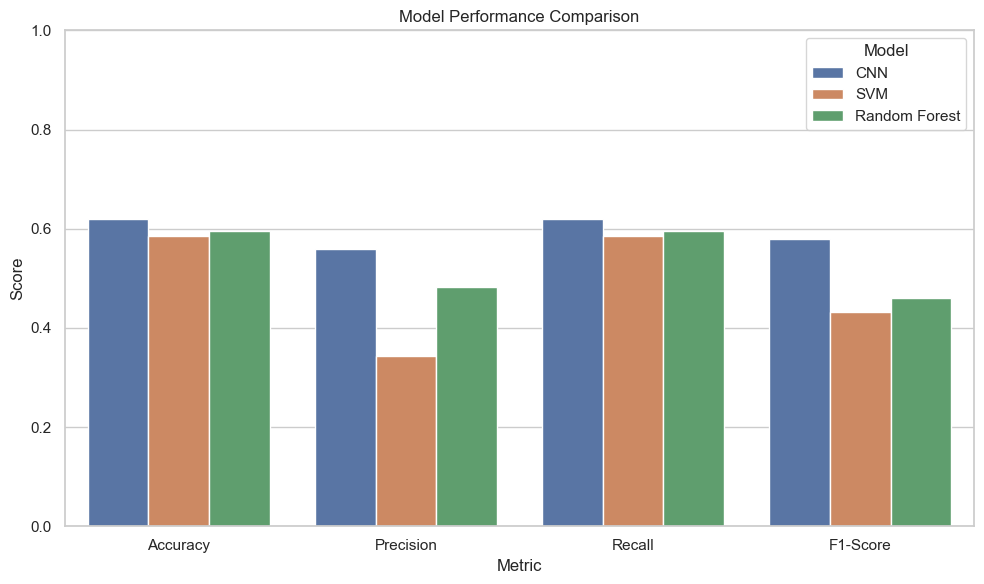

In [24]:
# === Bar Plot Comparison ===
df_melted = df_results.melt(id_vars="Model", var_name="Metric", value_name="Score")
plt.figure(figsize=(10, 6))
sns.barplot(x="Metric", y="Score", hue="Model", data=df_melted)
plt.title("Model Performance Comparison")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

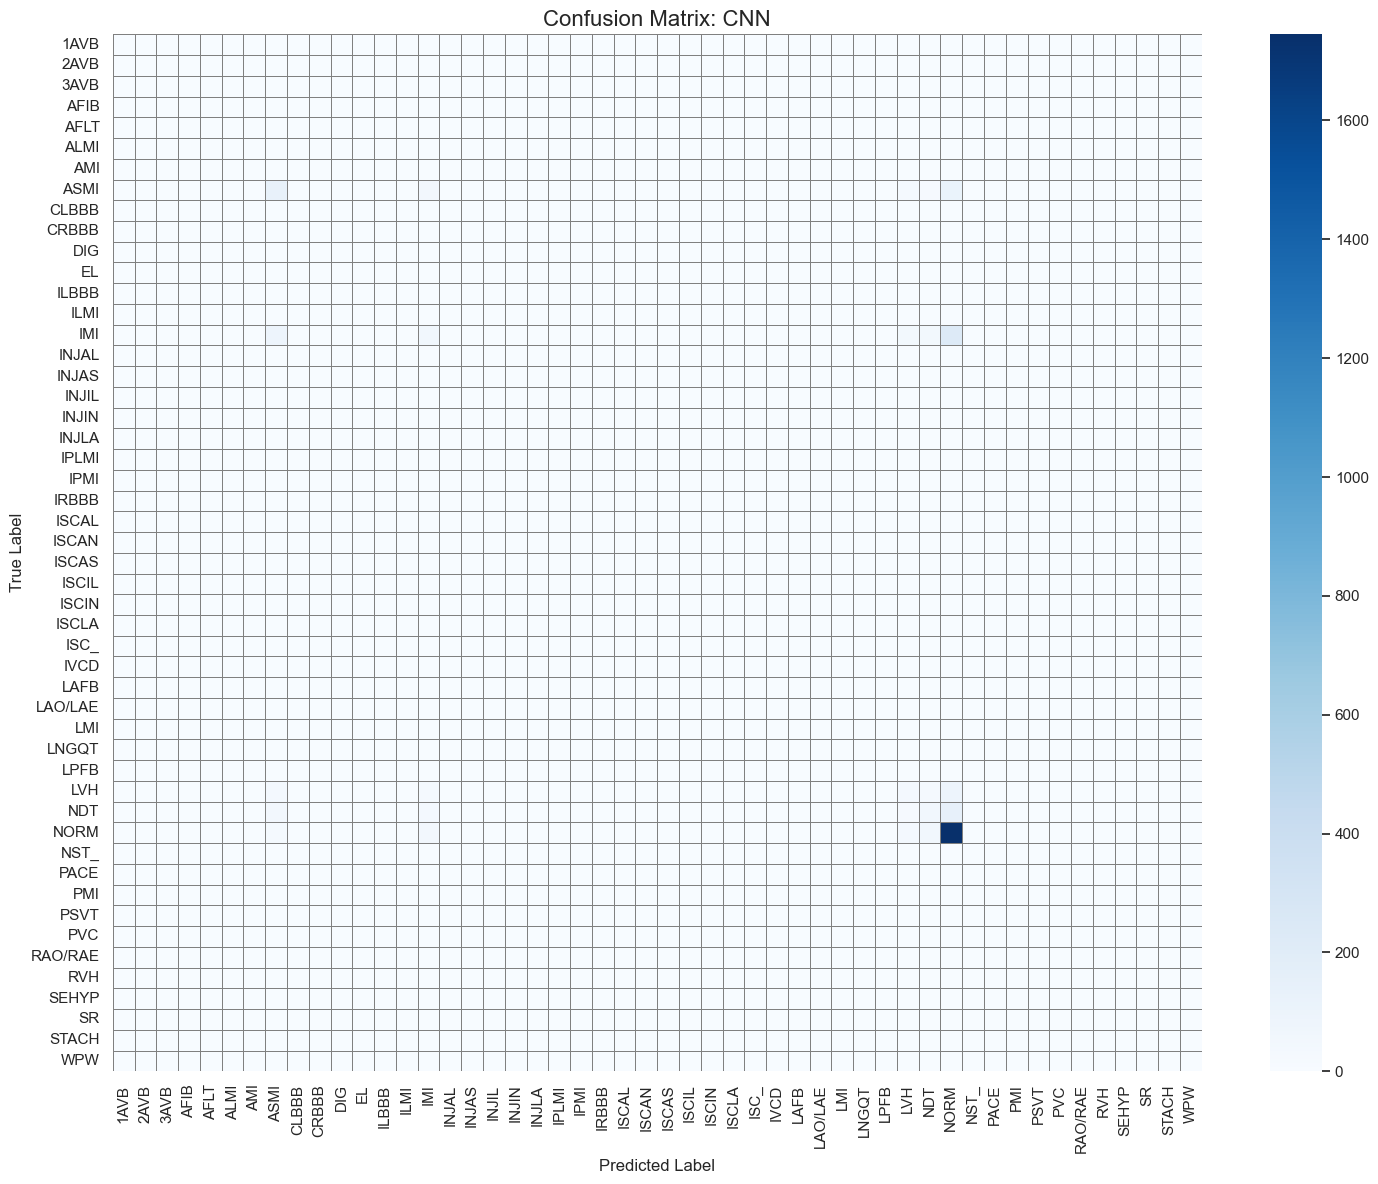

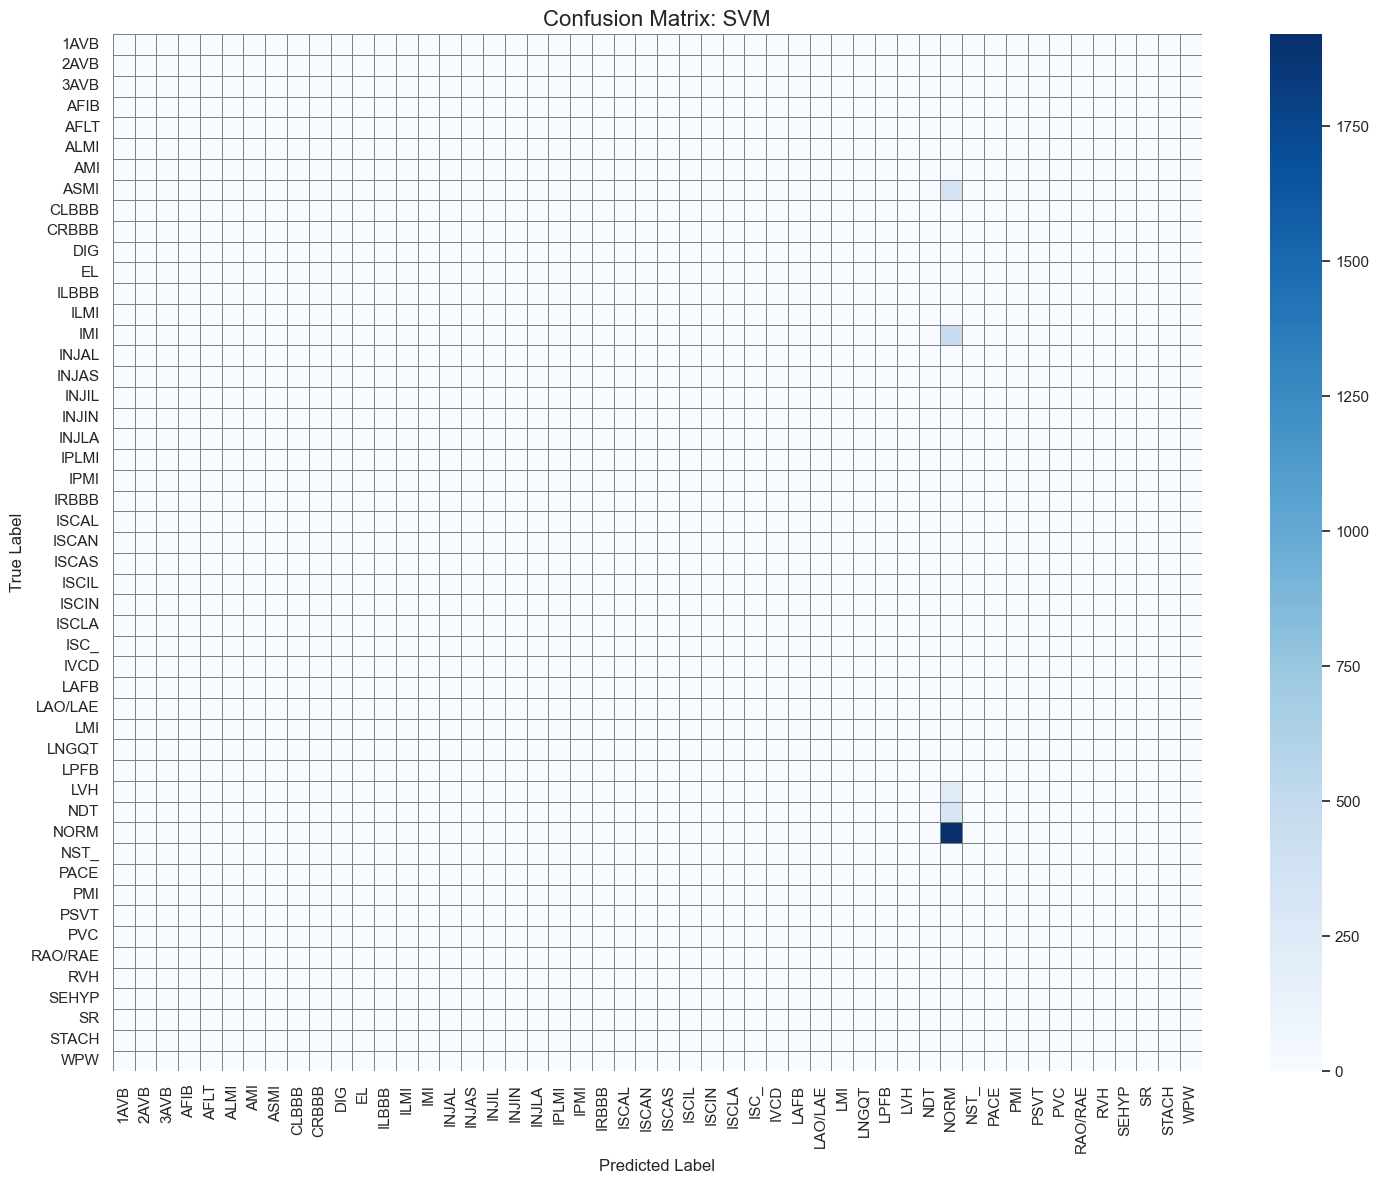

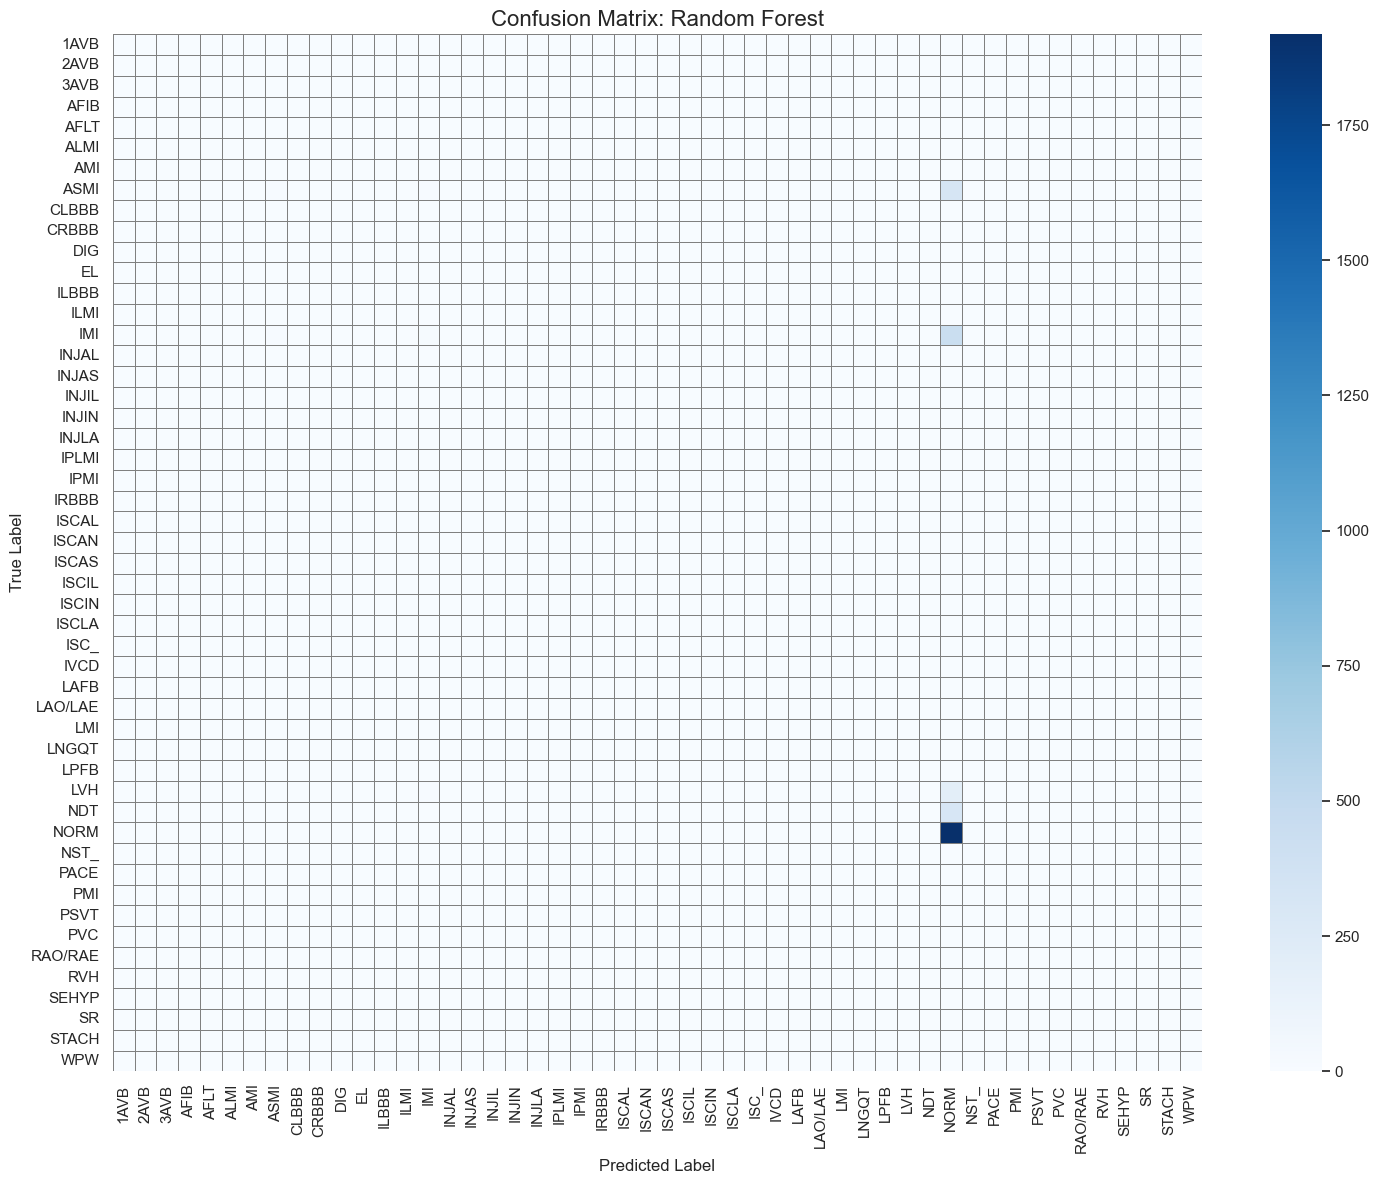

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# === Function to Plot Confusion Matrix ===
def plot_confusion_matrix(y_true, y_pred, model_name, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    plt.figure(figsize=(15, 12))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels,
                linewidths=0.5, linecolor='gray')
    
    plt.title(f"Confusion Matrix: {model_name}", fontsize=16)
    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# === Convert Encoded Labels Back to Strings ===
# Assuming you used LabelEncoder to encode class labels
# and that you have y_test_flat, y_pred_cnn, y_pred_svm, y_pred_rf available

y_true_str = label_encoder.inverse_transform(y_test_flat)
y_pred_str_cnn = label_encoder.inverse_transform(y_pred_cnn)
y_pred_str_svm = label_encoder.inverse_transform(y_pred_svm)
y_pred_str_rf = label_encoder.inverse_transform(y_pred_rf)

# Get string labels from encoder
class_labels = label_encoder.classes_

# === Plot Confusion Matrices for All Models ===
plot_confusion_matrix(y_true_str, y_pred_str_cnn, "CNN", class_labels)
plot_confusion_matrix(y_true_str, y_pred_str_svm, "SVM", class_labels)
plot_confusion_matrix(y_true_str, y_pred_str_rf, "Random Forest", class_labels)


1/1 [==============================] - 0s 32ms/step


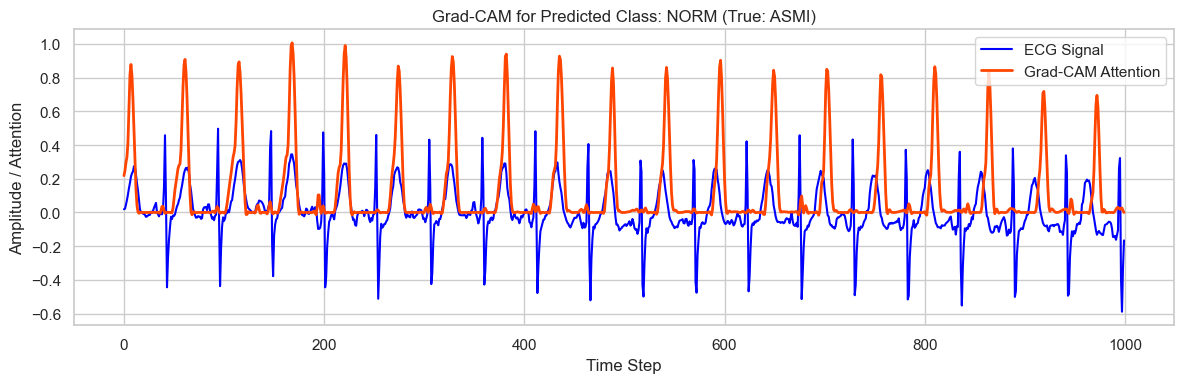

1/1 [==============================] - 0s 49ms/step


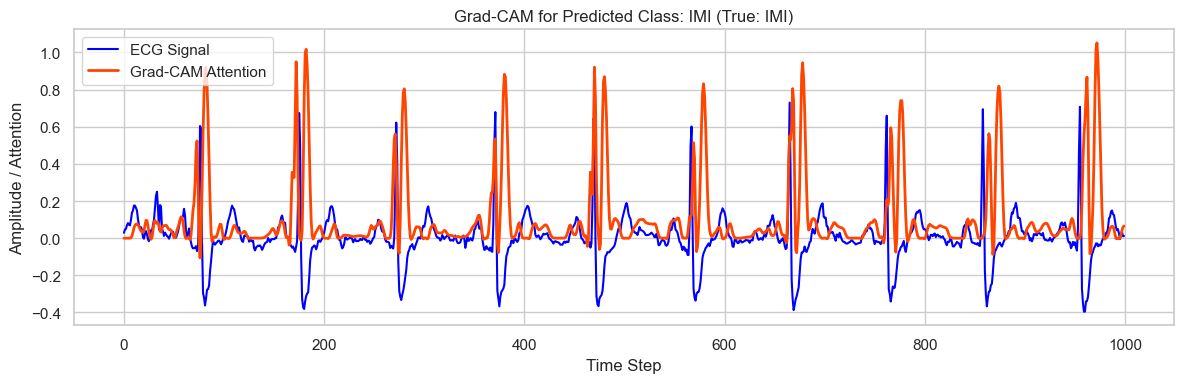

1/1 [==============================] - 0s 48ms/step


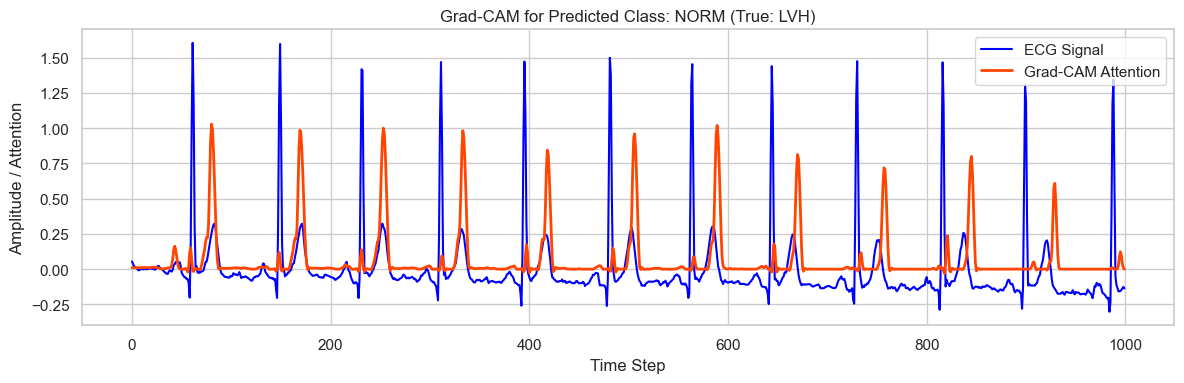

1/1 [==============================] - 0s 32ms/step


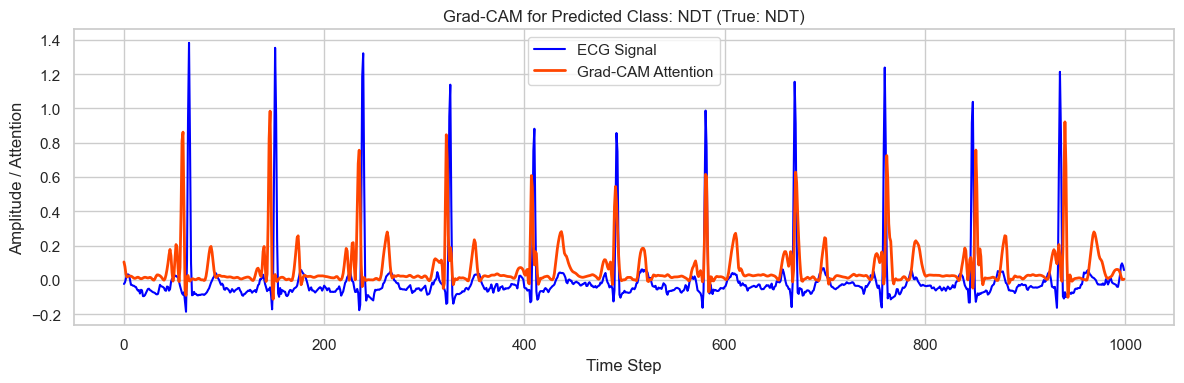

1/1 [==============================] - 0s 32ms/step


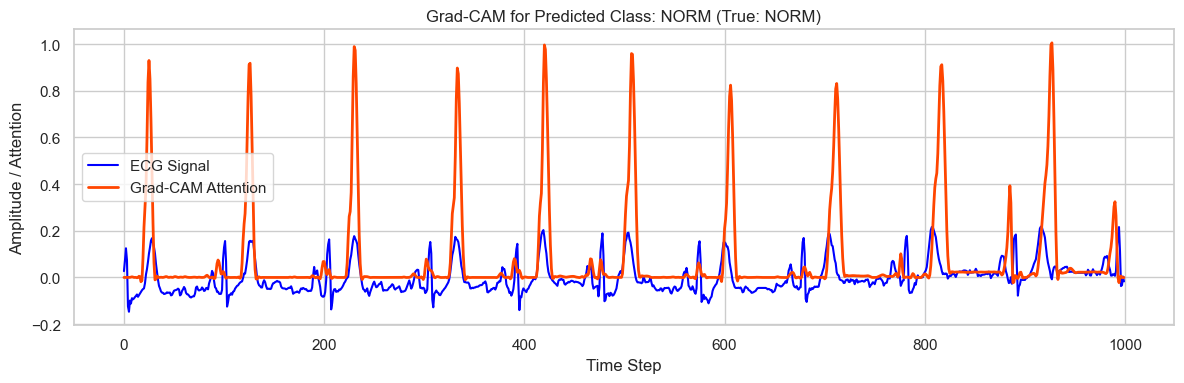

In [53]:
from scipy.ndimage import zoom

# Step 1: Get one test sample index per class
unique_classes = np.unique(y_test_flat)
example_indices = []

for cls in unique_classes:
    indices = np.where(y_test_flat == cls)[0]
    if len(indices) > 0:
        example_indices.append(indices[0])  # First occurrence of class in test set

# Step 2: Define Grad-CAM with interpolation
def compute_gradcam(model, input_data, label_index, target_len=1000):
    # Use the last Conv1D layer
    conv_layer = [layer for layer in model.layers if isinstance(layer, tf.keras.layers.Conv1D)][-1]
    grad_model = tf.keras.models.Model([model.inputs], [conv_layer.output, model.output])
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(input_data)
        loss = predictions[:, label_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=1)
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads[0], conv_outputs), axis=-1).numpy()
    
    # Normalize and interpolate heatmap to match input length
    heatmap = np.maximum(heatmap, 0)
    if np.max(heatmap) != 0:
        heatmap /= np.max(heatmap)
    
    heatmap_resized = zoom(heatmap, target_len / heatmap.shape[0])
    return heatmap_resized

# Step 3: Plot Grad-CAM per class
for idx in example_indices:
    sample_input = X_test[idx:idx+1]
    true_label = y_test_flat[idx]
    predicted_label = np.argmax(model.predict(sample_input), axis=1)[0]
    
    # Get full-length attention
    cam = compute_gradcam(model, sample_input, predicted_label, target_len=sample_input.shape[1])

    # Plot
    plt.figure(figsize=(12, 4))
    plt.plot(sample_input[0].squeeze(), label='ECG Signal', color='blue')
    plt.plot(cam, label='Grad-CAM Attention', color='orangered', linewidth=2)
    plt.title(f"Grad-CAM for Predicted Class: {label_encoder.classes_[predicted_label]} (True: {label_encoder.classes_[true_label]})")
    plt.xlabel("Time Step")
    plt.ylabel("Amplitude / Attention")
    plt.legend()
    plt.tight_layout()
    plt.show()